# Time Series - Forecasting example

###### Links: [Sales dataset (Kaggle)](https://www.kaggle.com/c/competitive-data-science-predict-future-sales)  |  [Article 1 (TowardsDataScience)](https://medium.com/@m.dipietro09/time-series-analysis-for-machine-learning-with-python-626bee0d0205)  |  [Article 2 (AnalyticsVidhya)](https://medium.com/analytics-vidhya/time-series-forecasting-with-random-walk-58e84c93058b)  |  [Article 3 (AnalyticsVidhya)](https://medium.com/analytics-vidhya/time-series-forecasting-arima-vs-lstm-vs-prophet-62241c203a3b) 

### 0 - Setup

###### Import pckgs 

In [1]:
import warnings
warnings.filterwarnings("ignore")
from ts_utils import *

###### Import data

In [2]:
dtf = pd.read_csv('data.csv')
dtf.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935844,10.10.2015,33,25,7409,299.0,1.0
2935845,09.10.2015,33,25,7460,299.0,1.0
2935846,14.10.2015,33,25,7459,349.0,1.0
2935847,22.10.2015,33,25,7440,299.0,1.0
2935848,03.10.2015,33,25,7460,299.0,1.0


In [3]:
dtf["date"] = pd.to_datetime(dtf['date'], format='%d.%m.%Y')

In [4]:
ts = dtf.groupby("date")["item_cnt_day"].sum().rename("sales")
ts.head()

date
2013-01-01    1951.0
2013-01-02    8198.0
2013-01-03    7422.0
2013-01-04    6617.0
2013-01-05    6346.0
Name: sales, dtype: float64

In [5]:
ts.tail()

date
2015-10-27    1551.0
2015-10-28    3593.0
2015-10-29    1589.0
2015-10-30    2274.0
2015-10-31    3104.0
Name: sales, dtype: float64

### 1 - TimeSeries Analysis

###### Check for:
- Trend 
- Outliers
- Stationarity
- Seasonality (define s)

###### Target Variable

In [6]:
print("population --> len:", len(ts), "| mean:", round(ts.mean()), " | std:", round(ts.std()))
w = 30
print("moving --> len:", w, " | mean:", round(ts.ewm(span=w).mean()[-1]), " | std:", round(ts.ewm(span=w).std()[-1]))

population --> len: 1034 | mean: 3528.0  | std: 1585.0
moving --> len: 30  | mean: 2305.0  | std: 773.0


###### Trend

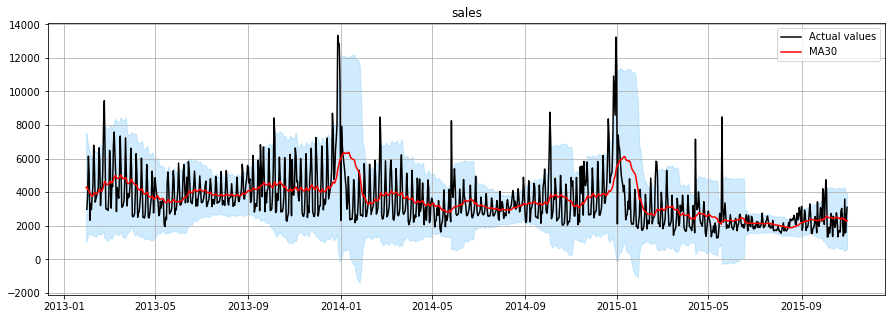

In [7]:
plot_ts(ts, plot_ma=True, plot_intervals=True, window=w, figsize=(15,5))

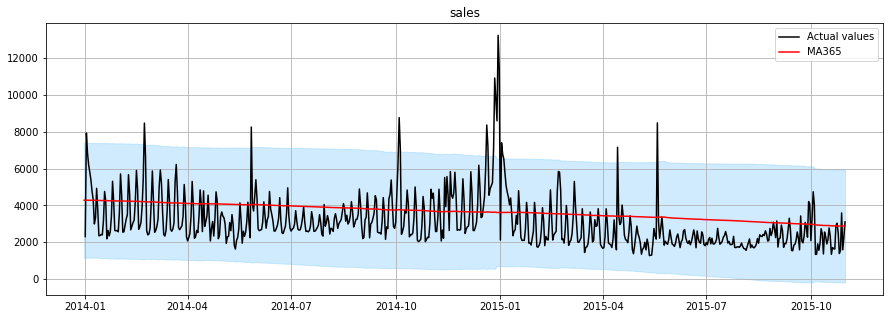

In [8]:
# looks like a soft downtrend, it should be clear with a window of 1 year
plot_ts(ts, plot_ma=True, plot_intervals=True, window=365, figsize=(15,5))

In [9]:
# -> I will use a linear ("additive") trend

###### Outliers

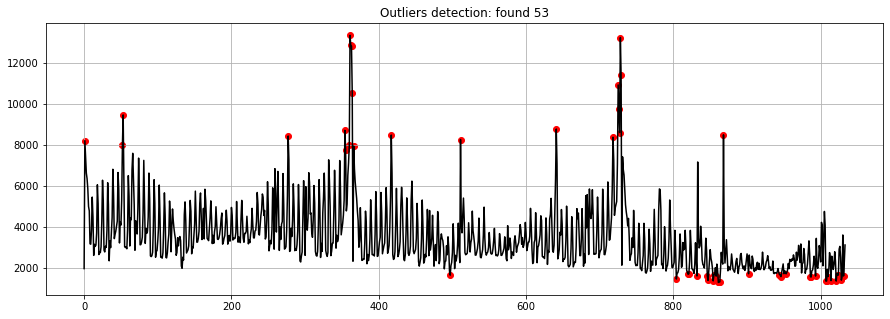

In [10]:
dtf_outliers = find_outliers(ts, perc=0.05, figsize=(15,5))

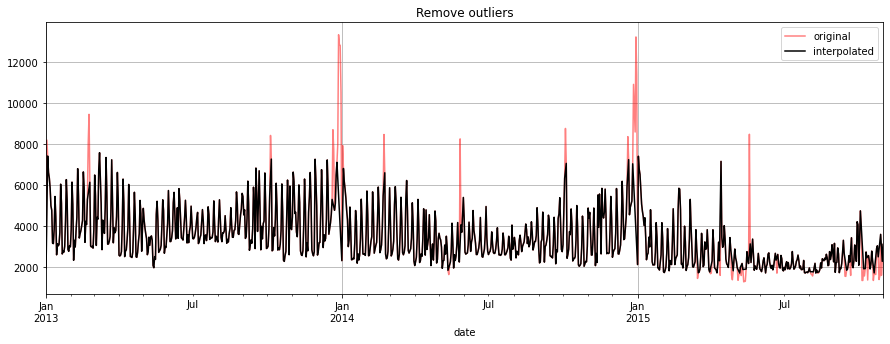

In [11]:
ts_clean = remove_outliers(ts, outliers_idx=dtf_outliers[dtf_outliers["outlier"]==1].index, figsize=(15,5))

In [12]:
# -> I will keep the outliers.

###### Stationarity

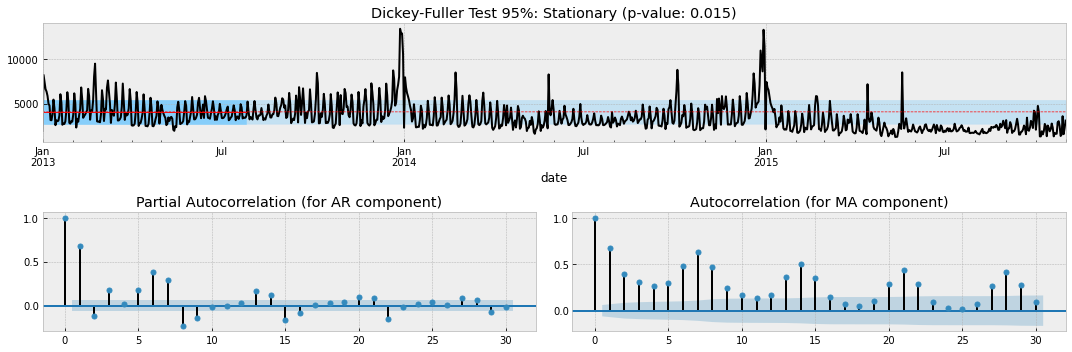

In [13]:
test_stationarity_acf_pacf(ts, sample=0.20, maxlag=w, figsize=(15,5))

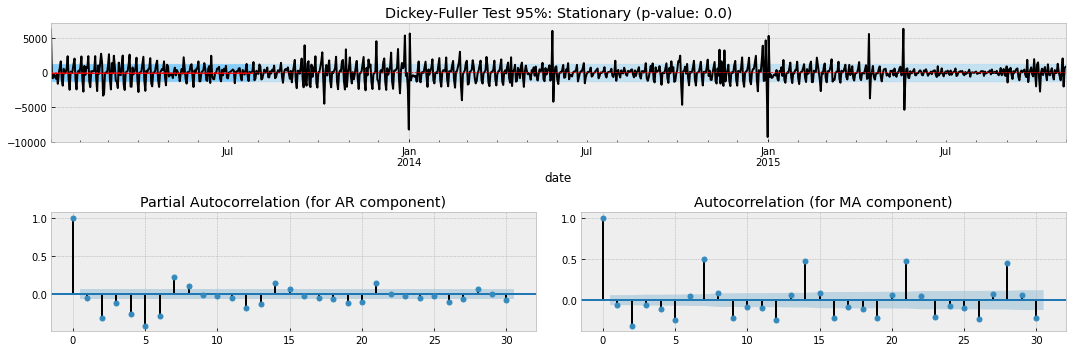

In [14]:
# I'm not sure: the test says it's stationary but it doesn't look like, let's try with differentiating the ts
test_stationarity_acf_pacf(diff_ts(ts, order=1), sample=0.20, maxlag=30, figsize=(15,5))

In [15]:
# CLearly there is stationarity every 2 days (negative: at the beginning of the week less sales) 
# and 7 days (positive: more sales on the weekend)
# -> I will use the raw ts.

###### Seasonality

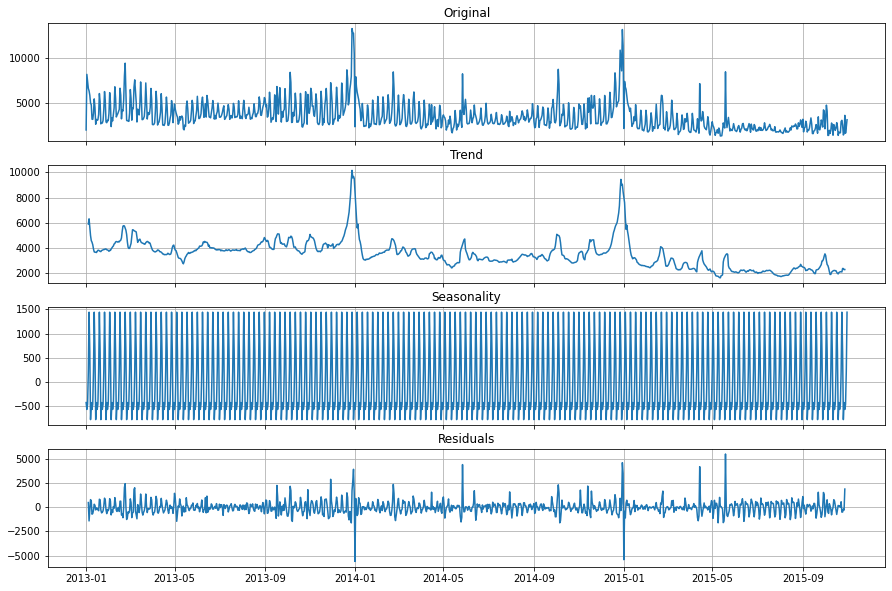

In [16]:
dic_decomposed = decompose_ts(ts, s=7, figsize=(15,10))

In [17]:
# -> Using weekly seasonality there are smaller residuals
s = 7

### 2 - Preprocessing

###### Differenciating

In [18]:
# I will use the raw ts

###### Partitioning

--- splitting at index:  881 | 2015-06-01 00:00:00 | test size: 0.15  ---


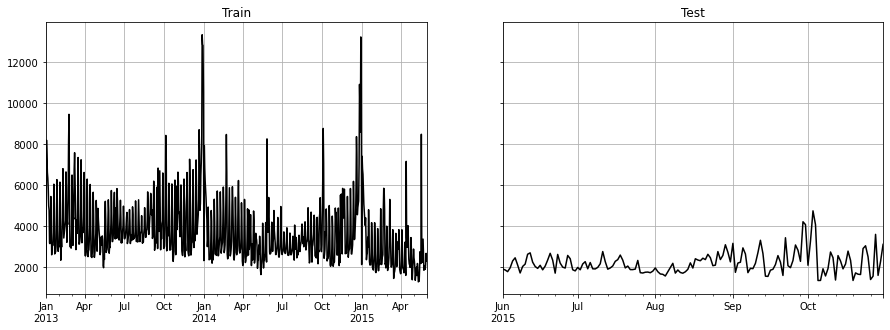

In [19]:
ts_train, ts_test = split_train_test(ts, exog=None, test="2015-06-01", plot=True, figsize=(15,5))

### 3 - Baseline (stochastic processes)

###### Train / Evaluate: Random Walk

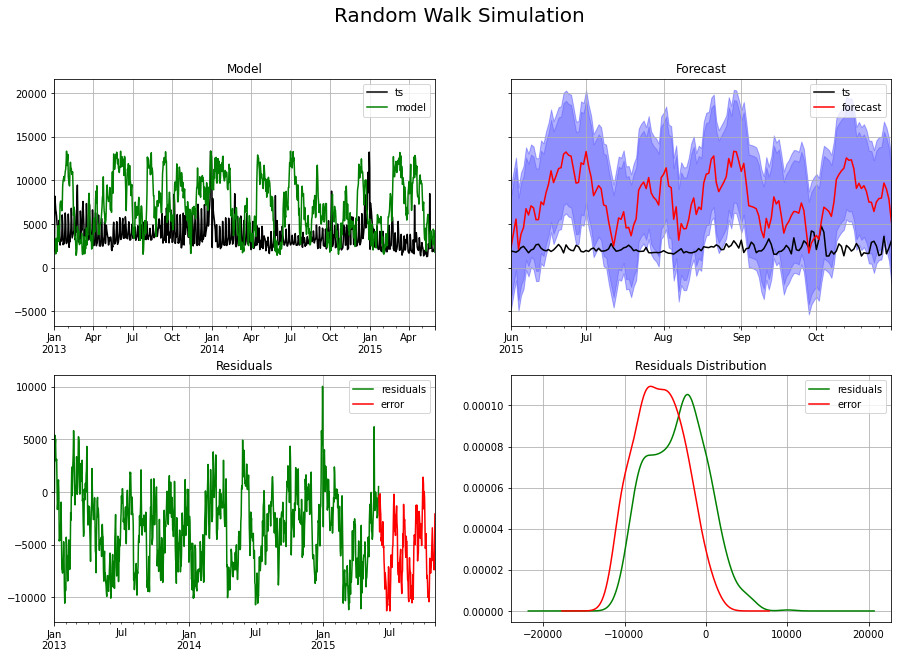

Training --> Residuals mean: -3454.0  | std: 3588.0
Test --> Error mean: -5682.0  | std: 2991.0  | mae: 5718.0  | mape: 280.0 %  | mse: 41175341.0  | rmse: 6417.0


In [20]:
dtf = simulate_rw(ts_train, ts_test, figsize=(15,10))

In [21]:
#-> Totally random, really bad. So the series is not random, there's autocorrelation.

###### Forecast unknown

--- generating index date --> start: 2015-11-01 00:00:00 | end: 2016-01-01 00:00:00 | len: 62 ---


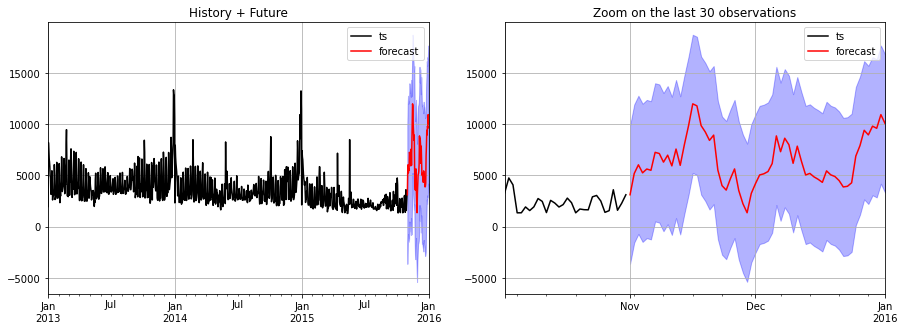

In [22]:
future = forecast_rw(ts, end="2016-01-01", freq="D", zoom=30, figsize=(15,5))

In [23]:
# Totally random. Let's try with Autoregressive models.

###### Train / Evaluate: Smoothing

Seasonal parameters: multiplicative Seasonality every 7 observations


//anaconda3/envs/snakes/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



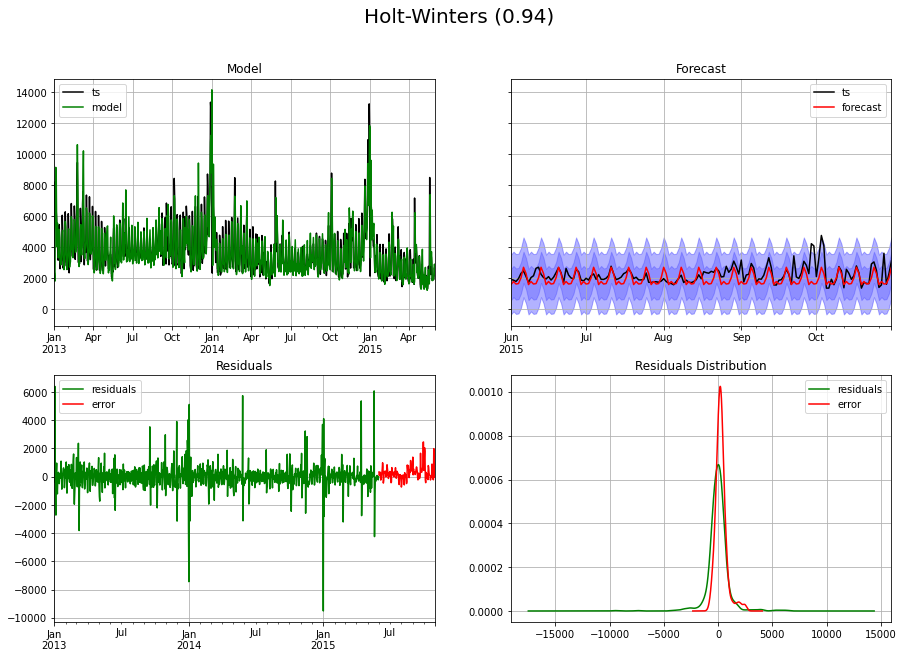

Training --> Residuals mean: -4.0  | std: 985.0
Test --> Error mean: 270.0  | std: 514.0  | mae: 392.0  | mape: 16.0 %  | mse: 335147.0  | rmse: 579.0


In [24]:
dtf, model = fit_expsmooth(ts_train, ts_test, trend="additive", seasonal="multiplicative", s=s, alpha=0.94, figsize=(15,10))

In [25]:
#-> On forecasting, the average error of prediction in 392 unit of sales (16% of the predicted value).

###### Train / Evaluate: SarimaX

In [26]:
# this takes a while
find_best_sarimax(ts_train, seasonal=True, stationary=False, s=s, exog=None,
                  max_p=10, max_d=3, max_q=10, 
                  max_P=1, max_D=1, max_Q=1)

//anaconda3/envs/snakes/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

//anaconda3/envs/snakes/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

//anaconda3/envs/snakes/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

//anaconda3/envs/snakes/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

//anaconda3/envs/snakes/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

//anaconda3/envs/snakes/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood op

best model --> (p, d, q): (1, 1, 1)  and  (P, D, Q, s): (1, 0, 1, 7)


//anaconda3/envs/snakes/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  881
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -7268.748
Date:                           Thu, 23 Jul 2020   AIC                          14549.496
Time:                                   18:13:28   BIC                          14578.176
Sample:                                        0   HQIC                         14560.464
                                           - 881                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0045      0.005     -0.908      0.364      -0.014       0.005
ar.L1          0.6904      0.012     56.539      0.000       0.666       0.714
ma.L1         -1.0000      0.019    -51.623      0.000      -1.038      -0.962
ar.S.L7        0.9927      0.003    373.669      0.000       0.987       0.998
ma.S.L7       -0.8855      0.018    -48.391      0.000      -0.921      -0.850
sigma2      8.627e+05   2.27e-08   3.79e+13      0.000    8.63e+05    8.63e+05
===================================================================================
Ljung-Box (Q):                       52.91   Jarque-Bera (JB):              9738.39
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               2.02   Skew:                             1.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.47e+27. Standard errors may be unstable.
"""

//anaconda3/envs/snakes/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

//anaconda3/envs/snakes/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Trend parameters: d=1
Seasonal parameters: Seasonality every 7 observations
Exog parameters: Not given


//anaconda3/envs/snakes/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



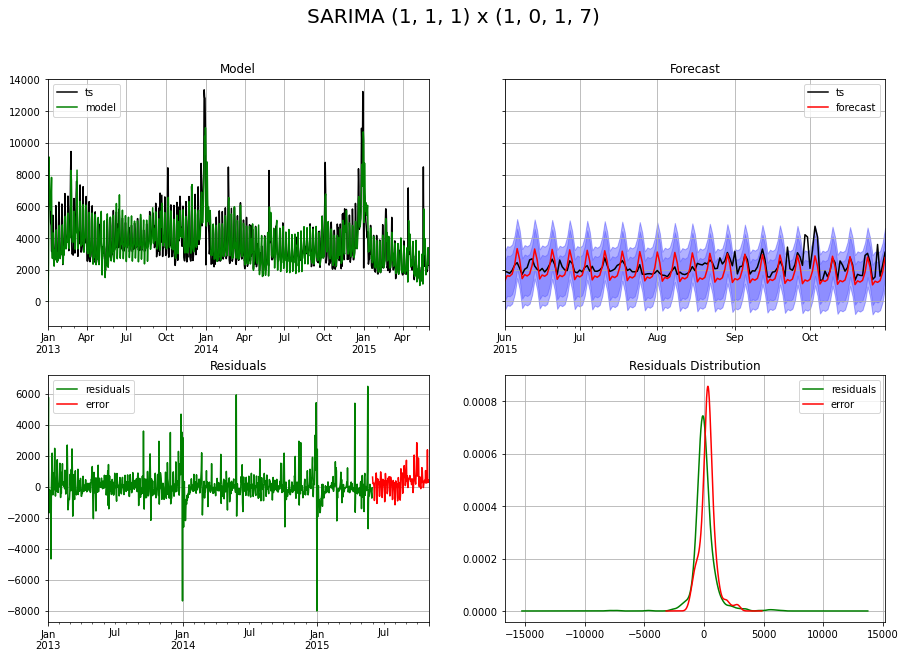

Training --> Residuals mean: 29.0  | std: 951.0
Test --> Error mean: 323.0  | std: 648.0  | mae: 540.0  | mape: 23.0 %  | mse: 521675.0  | rmse: 722.0


In [27]:
dtf, model = fit_sarimax(ts_train, ts_test, order=(1,1,1), seasonal_order=(1,0,1,s), figsize=(15,10))

In [28]:
#-> On forecasting, the average error of prediction in 394 unit of sales (17% of the predicted value).

###### Train / Evaluate: Garch

In [29]:
#fit_garch(ts_train, ts_test, order=(1,1,1), seasonal_order=(1,0,1,s), figsize=(15,10))

###### Forecast unknown 

In [30]:
#model = smt.ExponentialSmoothing(ts, trend="additive", seasonal="multiplicative", seasonal_periods=s)
model = smt.SARIMAX(ts, order=(1,1,1), seasonal_order=(1,0,1,s), exog=None)
#model = arch.garch...

//anaconda3/envs/snakes/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

//anaconda3/envs/snakes/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



--- generating index date --> start: 2015-11-01 00:00:00 | end: 2016-01-01 00:00:00 | len: 62 ---


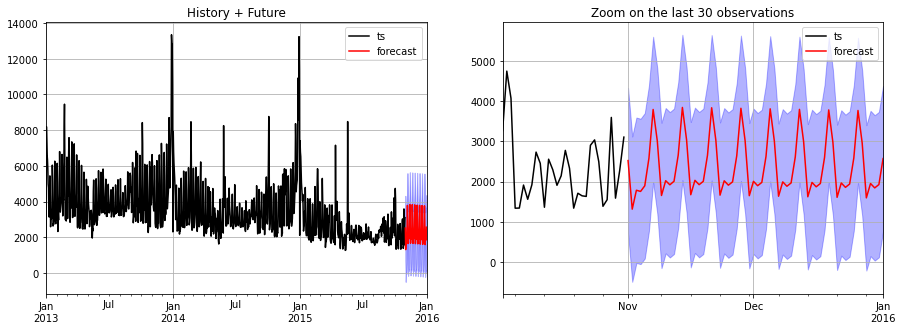

In [31]:
future = forecast_arima(ts, model, end="2016-01-01", zoom=30, figsize=(15,5))

In [32]:
#-> Autoregressive models predict that the series will keep the downtrend and there won't be any peaks next January.

### 4 - Model Desing & Testing (neural network)

###### Train / Evaluate

In [33]:
#-> Using s=7 Lstm will perform similar to Arima models. So I will try to expand the memory to 1y, 
# losing 365 days of training.
s = 365

In [34]:
model = models.Sequential()
model.add( layers.LSTM(input_shape=(1,s), units=50, activation='relu', return_sequences=False) )
model.add( layers.Dense(1) )
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                83200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 83,251
Trainable params: 83,251
Non-trainable params: 0
_________________________________________________________________


In [36]:
dtf, model = fit_lstm(ts_train, ts_test, model, exog=None, s=s, figsize=(15,10))

Seasonality: using the last 365 observations to predict the next 1


NameError: name 'epochs' is not defined

In [ ]:
#-> On forecasting, the average error of prediction in 1077 unit of sales (51% of the predicted value).

###### Forecast unknown 

In [ ]:
future = forecast_lstm(ts, model, end="2016-01-01", freq="D", zoom=30, figsize=(15,5))

In [ ]:
#-> Lstm with 1y of memory predicts that the series will replicate yearly seasonality, with peaks in January.

### 5 - Model Desing & Testing (prophet)

###### Train / Evaluate

In [ ]:
# Create dataframe with columns 'ds' (dates), 'y' (values), 'cap' (capacity if growth="logistic"), 
# other additional regressor
dtf_train = ts_train.reset_index().rename(columns={"date":"ds", "sales":"y"})
dtf_test = ts_test.reset_index().rename(columns={"date":"ds", "sales":"y"})

dtf_train.tail()

In [ ]:
# Create Holidays dataFrame with columns 'ds' (dates) and 'holiday' (string ex 'xmas')
dtf_holidays = None

In [ ]:
model = Prophet(growth="linear", changepoints=None, n_changepoints=25, seasonality_mode="multiplicative",
                yearly_seasonality="auto", weekly_seasonality="auto", daily_seasonality=False,
                holidays=dtf_holidays)

In [ ]:
dtf, model = fit_prophet(dtf_train, dtf_test, model=model, freq="D", figsize=(15,10))

In [ ]:
#-> On forecasting, the average error of prediction in 534 unit of sales (25% of the predicted value).

###### Forecast unknown 

In [ ]:
dtf = ts.reset_index().rename(columns={"date":"ds", "sales":"y"})
dtf.tail()

In [ ]:
model = Prophet(growth="linear", changepoints=None, n_changepoints=25, seasonality_mode="multiplicative",
                yearly_seasonality="auto", weekly_seasonality="auto", daily_seasonality=False,
                holidays=dtf_holidays)

In [ ]:
future = forecast_prophet(dtf, model, end="2016-01-01", freq="D", zoom=30, figsize=(15,5))

In [ ]:
#-> Prophet predicts that the series will keep the downtrend but includes yearly seasonality, with samller peaks in January.